Import all necessary libraries

In [7]:
import math
import os

import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# personal libraries
import plot
import preprocessor

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

Define dataset file locations

In [9]:
file_names = {
    "daily_gage_precip" : "dailyGagePrecip1956-2019.csv",
    "daily_watershed_precip" : "dailyWatershedPrecip1956-2019.csv",
    "daily_streamflow" : "HBEF_DailyStreamflow_1956-2017_longform.csv",
    "daily_snowwater" : "HBEF_snowwater1956-2018.csv"
}

this_path = os.getcwd()
dataset_path = os.path.join(this_path, "dataset")

Extract the run-off data from file

In [3]:
streamflow = pd.read_csv(os.path.join(dataset_path, file_names["daily_streamflow"]), names=["Date", "Watershed", "Streamflow"], header=0)
streamflow = pd.pivot_table(streamflow, values='Streamflow', 
                   index='Date',
                   columns='Watershed').reset_index('Date')
streamflow.head()

Watershed,Date,1,2,3,4,5,6,7,8,9
0,1956-01-01,0.274,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
1,1956-01-02,0.265,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
2,1956-01-03,0.251,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
3,1956-01-04,0.248,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
4,1956-01-05,0.250,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0


In [4]:
streamflow.shape

(22563, 10)

We have around 22300 time stamps to work with, and we'll use roughly 80% for training

In [5]:
TRAIN_SPLIT=18000

Set the seed to ensure reproducibility

In [6]:
tf.random.set_seed(64)

# Forecasting a single run-off using only previous run-off data

For the first part of this experiment, we will use one feature, the run-off from watershed 1, to predict future run-off from this watershed.

In [7]:
single_runoff_dataframe = streamflow[1]
single_runoff_dataframe.index = streamflow['Date']
single_runoff_dataframe.head()

Date
1956-01-01    0.274
1956-01-02    0.265
1956-01-03    0.251
1956-01-04    0.248
1956-01-05    0.250
Name: 1, dtype: float64

Plot roughly 3 years of data

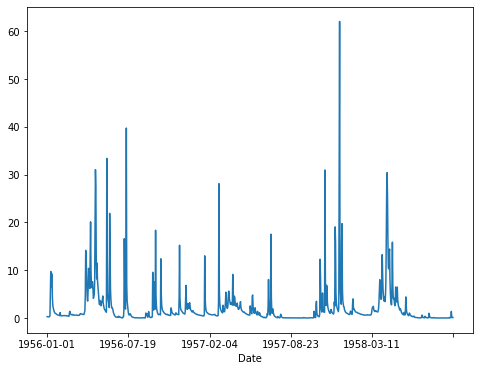

In [8]:
single_runoff_dataframe.iloc[:1000].plot()

Extract values from dataframe into numpy array and normalize

In [9]:
single_runoff = single_runoff_dataframe.values
single_runoff_mean = single_runoff[:TRAIN_SPLIT].mean()
single_runoff_std = single_runoff[:TRAIN_SPLIT].std()
single_runoff = (single_runoff - single_runoff_mean)/single_runoff_std
print("Shape: {0}, Max: {1}, Min: {2}".format(single_runoff.shape, single_runoff.max(), single_runoff.min()))

Shape: (22563,), Max: 22.950993622272136, Min: -0.4564675716258455


We will assume that a 60 day history will contain all significantly correlated data with future run-off values, and we will simply try to predict the next time step.

In [10]:
historic_timestamps = 20
future_targets = 0

input_train_runoff, target_train_runoff = preprocessor.univariate_data(single_runoff, 0, TRAIN_SPLIT,
                                                                        historic_timestamps, future_targets)
input_val_runoff, target_val_runoff = preprocessor.univariate_data(single_runoff, TRAIN_SPLIT, None,
                                                                        historic_timestamps, future_targets)

Plot historic data with target run-off to try to predict

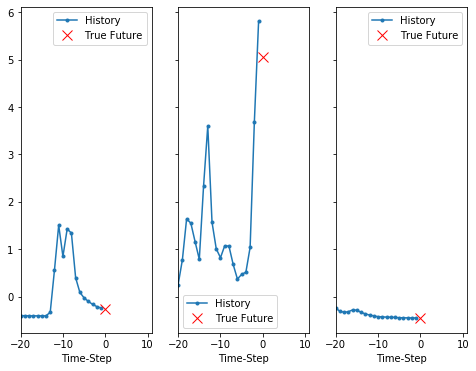

In [11]:
fig, axes = plt.subplots(1,3, sharey=True)
time_idx = [0, 100, 200]
for i in range(len(axes)):
    plot.plot_timeseries(axes[i], [input_train_runoff[time_idx[i]], target_train_runoff[time_idx[i]]])

Include some kind of baseline (Ellie?)

# Recurrent neural network
Next we will be using a Recurrent Neural Network (RNN) to predict the run-off. RNNs are well suited to time series data, processing time series step by step and keeping an internal state which summarizes the data seen so far.

We will now shuffle, batch and cache the dataset:

In [12]:
BATCH_SIZE = 128 # using smaller constants as less powerful hardware
BUFFER_SIZE = 1000

train_runoff = tf.data.Dataset.from_tensor_slices((input_train_runoff, target_train_runoff))
train_runoff = train_runoff.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_runoff = tf.data.Dataset.from_tensor_slices((input_val_runoff, target_val_runoff))
val_runoff = val_runoff.batch(BATCH_SIZE).repeat()

Create the model. We will using a simple RNN layer for now, the Adam optimizer for performant optimization, and the Mean Squared Error as loss due to meaningful spikes in the data.

In [13]:
simple_runoff_model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(8),
    tf.keras.layers.Dense(1)
])
simple_runoff_model.compile(optimizer='adam', loss='mse')

Perform sample prediction to check output of model:

In [14]:
for x, y in val_runoff.take(1):
    print(simple_runoff_model.predict(x).shape)

(128, 1)


Now we will train the model. To save time, we will only complete 100 steps per epoch instead of all of the training data, and we will train for 10 epochs.

In [15]:
STEPS_PER_EPOCH = 100
EPOCHS = 10
VALIDATION_STEPS=50

simple_runoff_model.fit(train_runoff, epochs=EPOCHS,
                        steps_per_epoch=STEPS_PER_EPOCH,
                        validation_data=val_runoff,
                        validation_steps=VALIDATION_STEPS)

Train for 100 steps, validate for 50 steps
Epoch 1/10
100/100 [==============================] - 6s 56ms/step - loss: 1.4058 - val_loss: 1.3193
Epoch 2/10
100/100 [==============================] - 4s 39ms/step - loss: 1.0198 - val_loss: 1.0212
Epoch 3/10
100/100 [==============================] - 4s 36ms/step - loss: 0.8660 - val_loss: 0.8521
Epoch 4/10
100/100 [==============================] - 4s 37ms/step - loss: 0.7399 - val_loss: 0.7624
Epoch 5/10
100/100 [==============================] - 4s 36ms/step - loss: 0.6948 - val_loss: 0.7187
Epoch 6/10
100/100 [==============================] - 4s 36ms/step - loss: 0.6321 - val_loss: 0.6989
Epoch 7/10
100/100 [==============================] - 4s 36ms/step - loss: 0.7020 - val_loss: 0.6853
Epoch 8/10
100/100 [==============================] - 3s 34ms/step - loss: 0.6272 - val_loss: 0.6812
Epoch 9/10
100/100 [==============================] - 4s 40ms/step - loss: 0.5962 - val_loss: 0.6756
Epoch 10/10
100/100 [===========================

The model seems to start to hit a minima after 5 or so epochs. Let's see the predictions the model makes on run-off values:

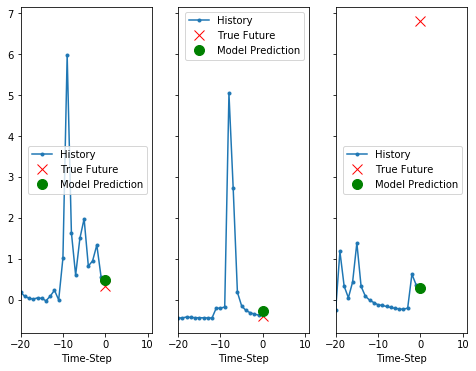

In [16]:
fig, axes = plt.subplots(1,3, sharey=True)
for i, (x, y) in enumerate(val_runoff.take(3)):
    plot.plot_timeseries(axes[i], [x[0].numpy(),
                                   y[0].numpy(),
                                   simple_runoff_model.predict(x)[0]])

The model predicts well when run-off is gradually falling after a rainfall, but obviously fails to predict rainfall which drives up the run-off again. Time for a larger model incorporating rain gage measurements across multiple watersheds, predicting the run-off at many points.

# Using rainfall measurements to aid prediction
Extract rain gage precipitation and pivot so that each rain gage has a column. We will ignore all measurements before all rain gages started being used.

In [23]:
gage_precip = pd.read_csv(os.path.join(dataset_path, file_names["daily_gage_precip"]), names=["Date", "RainGage", "Precipitation"], header=0)
# reshape so that raingage is also column
gage_precip = pd.pivot_table(gage_precip, values='Precipitation', 
                   index='Date',
                   columns='RainGage').reset_index('Date')
gage_precip.head()

RainGage,Date,RG1,RG10,RG11,RG12,RG13,RG14,RG15,RG16,RG17,...,RG23,RG24,RG25,RG3,RG4,RG5,RG6,RG7,RG8,RG9
0,1956-01-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1956-01-02,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1956-01-03,8.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,8.9,NaN,NaN,NaN,NaN,NaN,NaN
3,1956-01-04,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,1956-01-05,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


We can see from this data that not all rain gages have data collected from them on every date, and exploring the data shows that there are actually no dates where data from all rain fall gages are collected. We could find a trade-off of a date range where there are a reasonable number of rain fall gages being measured and just use that limited set, but instead due to the spatial correlation I have opted for an approach of replacing the missing values with a distance weighted average of the present values.

QGIS was used to create a distance matrix of all of the rain gage locations, and this matrix was exported to CSV. First we import the CSV:

In [10]:
gage_distances = pd.read_csv(os.path.join(dataset_path, "distanceMatrix.csv"), 
                             usecols=[1,2,3],
                             delimiter="	")
gage_distances.head()

,InputID,TargetID,Distance
0,1,2,362.863060
1,1,3,776.637314
2,1,4,467.243284
3,1,5,955.220015
4,1,6,985.729329


Now using these distances to fill in values using a weighted mean:

In [49]:
def get_distance(gage_a, gage_b, weights):
    cell = weights.query('InputID=={0}&TargetID=={1}'.format(gage_a,gage_b))['Distance']
    return cell.values[0]

def replace_nan_with_weighted_mean(dataset, weights):
    for index, row in dataset.iterrows():
        present_values = {}
        for col, value in row.iteritems():
            if not math.isnan(value):
                present_values[col[2:]] = value
                
        for col, value in row.iteritems():
            if math.isnan(value):
                accu = 0
                total_dist = 0
                for key, val in present_values.items():
                    try:
                        dist = get_distance(key, col[2:], weights)
                    except IndexError:
                        dist = 1
                    accu += val * dist
                    total_dist += dist
                new_val = accu / total_dist
                dataset.at[index,col] = new_val   
    
    return dataset
        
gage_precip_filled = replace_nan_with_weighted_mean(gage_precip.drop('Date', axis=1),
                                                    gage_distances)
gage_precip_filled.head()

RainGage,RG1,RG10,RG11,RG12,RG13,RG14,RG15,RG16,RG17,RG18,...,RG23,RG24,RG25,RG3,RG4,RG5,RG6,RG7,RG8,RG9
0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
1,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
2,8.1,8.516172,8.56797,8.542264,8.542384,8.543491,8.544963,8.543361,8.546113,8.533333,...,8.552401,8.549234,8.553154,8.9,8.587625,8.50849,8.452668,8.527525,8.651217,8.501347
3,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
4,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000


Add Date column back to dataframe and save to file:

In [51]:
gage_precip_filled['Date'] = gage_precip['Date']
gage_precip_filled.to_csv(os.path.join(dataset_path, "distanceInterpolatedDailyGagePrecip.csv"))
gage_precip_filled.head()

RainGage,RG1,RG10,RG11,RG12,RG13,RG14,RG15,RG16,RG17,RG18,...,RG24,RG25,RG3,RG4,RG5,RG6,RG7,RG8,RG9,Date
0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1956-01-01
1,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1956-01-02
2,8.1,8.516172,8.56797,8.542264,8.542384,8.543491,8.544963,8.543361,8.546113,8.533333,...,8.549234,8.553154,8.9,8.587625,8.50849,8.452668,8.527525,8.651217,8.501347,1956-01-03
3,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1956-01-04
4,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1956-01-05


In [26]:
gage_precip.head()

RainGage,Date,RG1,RG10,RG11,RG12,RG13,RG14,RG15,RG16,RG17,...,RG23,RG24,RG25,RG3,RG4,RG5,RG6,RG7,RG8,RG9
0,1956-01-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1956-01-02,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1956-01-03,8.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,8.9,NaN,NaN,NaN,NaN,NaN,NaN
3,1956-01-04,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,1956-01-05,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN


Do the same for the snowwater equivalent data

In [ ]:
snowwater = pd.read_csv(os.path.join(dataset_path, file_names["daily_snowwater"]),
                        names=["Winter","Date","STA1","STA2","STA3","STA4","STA5", \
                               "STA6","STA7","STA8","STA9","STA10","STA11","STA12", \
                               "STA13","STA14","STA15","STA16","STA17","STA19","STA20","STA21","STAHQ"], header=0)
snowwater.head()

# Further Work
Predict missing rainfall and snowwater values with some kind of network learning method, possible including more variables such as wind speed and direction, temperature values